# All in one example

In this example: 

- Drillhole / data preparation
 - we import and clean drillhole database
 - desurvey database
 - export to vtk for visual validation 
- Block model preparation 
 - Fill blocks (entire model)
 - Select blocks below the topo
- Estimation
 - Estimate distance from drillhole 
 - Estimate with ID2 Au grade in blocks (point estimation)

## Drillhole and data preparation


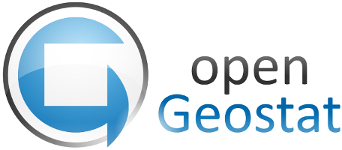

In [1]:
# import required libraries
import pygslib as gslib
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
%matplotlib inline

In [2]:
# import data from file
collar = pd.read_csv('../datasets/dhole_data2/collar.csv')
survey = pd.read_csv('../datasets/dhole_data2/survey.csv')
assay = pd.read_csv('../datasets/dhole_data2/assay.csv')
litho = pd.read_csv('../datasets/dhole_data2/litho.csv')

#sort all
collar.sort_values(by=['BHID'], inplace=True)
survey.sort_values(by=['BHID', 'AT'], inplace=True)
assay.sort_values(by=['BHID', 'FROM'], inplace=True)
litho.sort_values(by=['BHID', 'FROM'], inplace=True)

In [3]:
# test duplicates in collar
print collar.columns
print collar['BHID'].shape[0]
print collar['BHID'].unique().shape[0]

Index([u'Unnamed: 0', u'BHID', u'XCOLLAR', u'YCOLLAR', u'ZCOLLAR', u'AZ_UTM',
       u'DIP', u'LENGTH_M', u'NO_DATA', u'DOUBTFUL_C'],
      dtype='object')
1083
1083


In [4]:
# review columns names (you can do this in excel...)
print survey.columns
print assay.columns
print litho.columns

Index([u'Unnamed: 0', u'BHID', u'AT', u'AZ', u'DIP'], dtype='object')
Index([u'Unnamed: 0', u'BHID', u'FROM', u'TO', u'AU_AVG_GT'], dtype='object')
Index([u'Unnamed: 0', u'BHID', u'FROM', u'TO', u'LITHO_DESC'], dtype='object')


In [5]:
# review some row values (you can do this in excel...)
print survey.head(5)
print assay.head(5)
print litho.head(5)

   Unnamed: 0   BHID      AT      AZ  DIP
0           4     10    0.00  173.31   43
1           5     10   30.48  173.31   47
2         231  10165    0.00  182.31   90
3         232  10165   60.96  182.31   88
4         233  10165  121.92  182.31   87
   Unnamed: 0 BHID      FROM        TO  AU_AVG_GT
0          23   10  27.91968  29.13888     11.314
1          24   10  29.13888  30.02280      2.743
2          25   10  30.02280  30.66288     20.571
3          26   10  30.66288  32.18688     51.771
4          27   10  32.18688  32.64408      3.600
   Unnamed: 0   BHID   FROM     TO                    LITHO_DESC
0          14     10   0.00   5.48                        Casing
1          15     10   5.48  25.90                 Early Diorite
2          16     10  25.90  28.95  Felsic to Intermediate Dykes
3          17     10  28.95  39.92                    Shear Zone
4         566  10165   0.00   3.65                        Casing


In [6]:
# verify that datatypes are correct. We don't want BHIDs with different dtypes or Grade as 'str'  
print survey.dtypes
print assay.dtypes
print litho.dtypes

Unnamed: 0      int64
BHID           object
AT            float64
AZ            float64
DIP           float64
dtype: object
Unnamed: 0      int64
BHID           object
FROM          float64
TO            float64
AU_AVG_GT     float64
dtype: object
Unnamed: 0      int64
BHID           object
FROM          float64
TO            float64
LITHO_DESC     object
dtype: object


###  Clean a bit the data

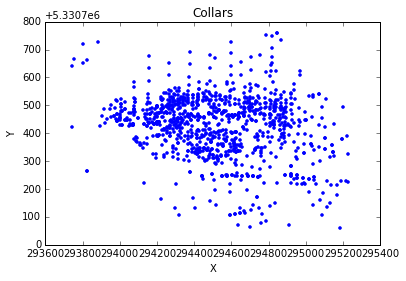

In [7]:
# plot collars as points
plt.plot (collar['XCOLLAR'],collar['YCOLLAR'], '.')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Collars')
plt.show()

In [8]:
# find some undesired underground drillholes
# visualize drillholes with problems
print survey[(survey['DIP']<=0) & (survey['AT']==0)]

# make list of bad drillholes
bad = survey['BHID'][(survey['DIP']<=0) & (survey['AT']==0)].unique()
print bad

      Unnamed: 0   BHID  AT    AZ  DIP
2942       20493  18809   0  2.31   -0
2944       20496  18810   0  2.31   -0
2946       20498  18811   0  2.31   -0
2949       20501  18812   0  2.31   -0
2952       20504  18813   0  2.31   -0
2956       20508  18814   0  2.31   -0
2960       20516  18816   0  2.31   -0
2962       20518  18817   0  2.31   -0
2964       20520  18818   0  2.31   -0
2965       20521  18819   0  2.31   -0
3017       20576  18846   0  2.31   -0
3018       20577  18848   0  2.31   -0
3019       20579  18851   0  2.31   -0
3020       20580  18852   0  2.31   -0
3021       20581  18856   0  2.31   -0
3022       20582  18857   0  2.31   -0
3023       20583  18858   0  2.31   -0
3024       20584  18859   0  2.31   -0
3654       54198   M-72   0  2.31  -90
['18809' '18810' '18811' '18812' '18813' '18814' '18816' '18817' '18818'
 '18819' '18846' '18848' '18851' '18852' '18856' '18857' '18858' '18859'
 'M-72']


In [9]:
#remove bad drillholes 
collar = collar[~collar['BHID'].isin(bad)]

In [10]:
# more cleanup
#Remove what is not in collar
survey = survey[survey['BHID'].isin(collar['BHID'].values)]
assay = assay[assay['BHID'].isin(collar['BHID'].values)]
litho = litho[litho['BHID'].isin(collar['BHID'].values)]

In [11]:
#save "clean" data
collar.to_csv('collar_clean.csv')
survey.to_csv('survey_clean.csv')
assay.to_csv('assay_clean.csv')
litho.to_csv('litho_clean.csv')

### Create drillhole object

In [12]:
from pygslib.drillhole import *

In [13]:
#create database
mydholedb=Drillhole(collar=collar,survey=survey)
mydholedb.addtable(assay, 'assay' ,overwrite = False)
mydholedb.addtable(litho, 'litho', overwrite = False)

/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! Collar table without LENGTH field
  from ipykernel import kernelapp as app


In [14]:
#validate
mydholedb.validate()

/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 10399. This will produce error at desurvey
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 11241. This will produce error at desurvey
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 11242. This will produce error at desurvey
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 11263. This will produce error at desurvey
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: ! survey with one value at BHID: 11264. This will produce error at desurvey
  from ipyk

In [15]:
# fixing the issue of single interval at survey table
mydholedb.fix_survey_one_interval_err(900.)

In [16]:
#validate table assay
mydholedb.validate_table('assay')

/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 10398 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 10399 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11241 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11242 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11263 not at table assay
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 11264 not at table ass

In [17]:
#validate table litho
mydholedb.validate_table('litho')


/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID 18843A not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID CE-5295-7 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID G-8 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-68 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-69 not at table litho
  from ipykernel import kernelapp as app
/home/adrian/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Info : collar BHID M-70 not at table lit

### Work around litho code

In [18]:
# see lithocode list
lclass = mydholedb.table['litho']['LITHO_DESC'].unique()
lclass

array(['Casing', 'Early Diorite', 'Felsic to Intermediate Dykes',
       'Shear Zone', 'Intermediate to Ultramafic Volcanics',
       'Indifferenciated Tuffs', 'No Litho', 'Diorite', 'Diabase',
       'Quartz-Tourmaline Veins', 'Granodiorite', 'Fault', 'Mafic Dykes'], dtype=object)

In [19]:
# create litho ID numeric
mydholedb.table['litho']['lithoID']=np.NaN

i=0
for l in lclass: 
    i+=1
    mydholedb.table['litho'].loc[litho.LITHO_DESC==l,'lithoID']=i
    print i, l

1 Casing
2 Early Diorite
3 Felsic to Intermediate Dykes
4 Shear Zone
5 Intermediate to Ultramafic Volcanics
6 Indifferenciated Tuffs
7 No Litho
8 Diorite
9 Diabase
10 Quartz-Tourmaline Veins
11 Granodiorite
12 Fault
13 Mafic Dykes


In [20]:
# merge some types
mydholedb.table['litho'].loc[mydholedb.table['litho']['lithoID']==7, 'lithoID'] = 0 # no litho equal to zero
mydholedb.table['litho'].loc[mydholedb.table['litho']['lithoID']==8, 'lithoID'] = 2 # merge Diorite, Early Diorite
mydholedb.table['litho'].loc[mydholedb.table['litho']['lithoID']==12, 'lithoID'] = 4 # merge Fault, Shear Zone

In [21]:
# see table
mydholedb.table['litho'][['lithoID', 'LITHO_DESC']].drop_duplicates()

,lithoID,LITHO_DESC
0,1,Casing
1,2,Early Diorite
2,3,Felsic to Intermediate Dykes
3,4,Shear Zone
5,5,Intermediate to Ultramafic Volcanics
10,6,Indifferenciated Tuffs
25,0,No Litho
72,2,Diorite
121,9,Diabase
509,10,Quartz-Tourmaline Veins


In [22]:
# see results
mydholedb.table['litho'].head()

,Unnamed: 0,BHID,FROM,TO,LITHO_DESC,lithoID
0,14,10,0.00,5.48,Casing,1
1,15,10,5.48,25.90,Early Diorite,2
2,16,10,25.90,28.95,Felsic to Intermediate Dykes,3
3,17,10,28.95,39.92,Shear Zone,4
4,566,10165,0.00,3.65,Casing,1


<div class="alert alert-info">
    **Note**: The litho external table **is not** sharing memory with the litho table in the drillhole database.
</div>

In [23]:
# data is shared in memory?
print id(mydholedb.table['litho'])
print id(litho)
print 'data is shared in memory? ', id(litho)== id(mydholedb.table['litho'])

140418848611664
140418847362384
data is shared in memory?  False


### Merge tables

Merging table will split interval from to tables in order to make FROM-TO equal in each interval. If the two tables have the same field, example ``Au`` and ``Au`` a prefix will be added and the result will have ``Au_A`` and ``Au_B``. In addition a new column with key ``_merge`` will be created to denote what interval are  in both tables, in the left table (A) or in the right table (B)

In [24]:
# first add gaps
gap_assay,overlap_assay = mydholedb.add_gaps(table_name='assay', new_table_name='assay_no_gaps')
gap_litho,overlap_litho = mydholedb.add_gaps(table_name='litho', new_table_name='litho_no_gaps')

# review errors 
print len(gap_assay),len(overlap_assay)
print len(gap_litho),len(overlap_litho)

5043 4
0 0


In [25]:
# see overlaps
print overlap_assay

[4042, 32648, 20514, 20515]


In [26]:
# see where is this overlap
mydholedb.table['assay'][mydholedb.table['assay']['_id0']>4040].head()

# note that at _id0 = 4042 TO is 43. and at _id0 = 4043 FROM is 14... 
# for now we will ignore this but we may see how this was fixed in the table without gaps

,Unnamed: 0,BHID,FROM,TO,AU_AVG_GT,_id0
4041,104246,16707,18.53184,19.32432,0.1540,4041
4042,104247,16708,12.19200,43.28160,3.2055,4042
4043,104248,16708,14.29512,15.05712,8.0740,4043
4044,104249,16708,18.10512,18.95856,1.2170,4044
4045,104250,16708,21.54936,22.03704,0.1540,4045


In [27]:
# see where is this overlap
mydholedb.table['assay_no_gaps'][mydholedb.table['assay_no_gaps']['_id0']>4040].head()

# note that the overlap was truncated to TO=14.29

,BHID,FROM,TO,_id0,Unnamed: 0,AU_AVG_GT
3847,16707,18.53184,19.32432,4041,104246,0.1540
3786,16708,12.19200,14.29512,4042,104247,3.2055
3787,16708,14.29512,15.05712,4043,104248,8.0740
3789,16708,18.10512,18.95856,4044,104249,1.2170
3791,16708,21.54936,22.03704,4045,104250,0.1540


### Merging tables

<div class="alert alert-warning">
    **Warning**: The function merge was designed to work with drillholes without gaps and overlap. Don't use merge without add_gaps first. 
</div>

We will merge assay and litho table in order to be able to do some exploratory analysis. 


In [28]:

mydholedb.merge(table_A = 'assay_no_gaps', table_B = 'litho_no_gaps', new_table_name = 'dhole',
                          overwrite =False, tol=0.01, clean=True)

In [29]:
mydholedb.table['dhole'].head()

,BHID,FROM,TO,_id0,_id1,Unnamed: 0,AU_AVG_GT,Unnamed: 0__tmp__,LITHO_DESC,lithoID
0,10,0.00000,5.48000,0,0,NaN,NaN,51770,Casing,1
1,10,5.48000,25.90000,0,1,NaN,NaN,51771,Felsic to Intermediate Dykes,3
2,10,25.90000,27.91968,0,2,NaN,NaN,51772,Intermediate to Ultramafic Volcanics,5
3,10,27.91968,29.04444,1,2,137823,0.005,51772,Intermediate to Ultramafic Volcanics,5
4,10,29.04444,30.02280,2,3,137824,0.029,51773,Felsic to Intermediate Dykes,3


### Some quick stats 

This is to show what you can do with the merged table, but not a demonstration on exploratory data analysis

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5cc001950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fb5cbadfd50>]], dtype=object)

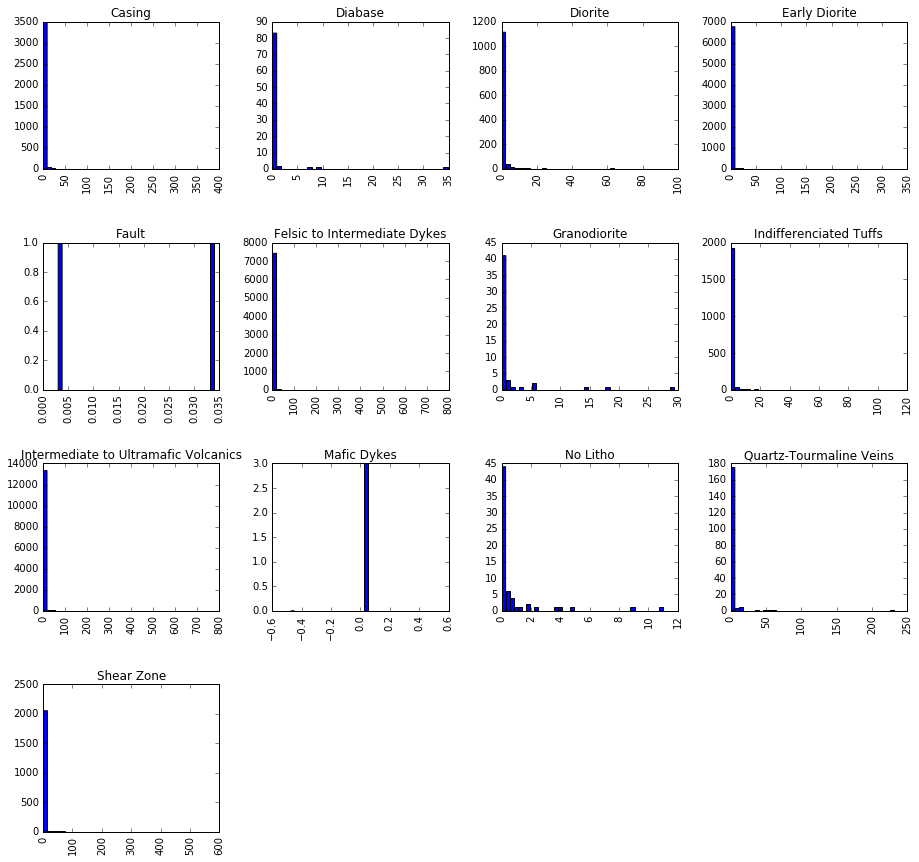

In [30]:
# histograms of Au by lithology
mydholedb.table['dhole']['AU_AVG_GT'].hist(by=mydholedb.table['dhole']['LITHO_DESC'], bins=40, figsize=(15, 15))

### Zero length intervals?

<div class="alert alert-warning">
    **Warning**: Merging produces zero (or almost zero) length intervals.  
</div>


In [31]:
mydholedb.table['dhole'][mydholedb.table['dhole']['TO']-mydholedb.table['dhole']['FROM']<0.01].head()

,BHID,FROM,TO,_id0,_id1,Unnamed: 0,AU_AVG_GT,Unnamed: 0__tmp__,LITHO_DESC,lithoID
249,10402,110.1840,110.03280,194,72,137772,0.0025,51698,Felsic to Intermediate Dykes,3
255,10402,114.6338,114.60480,200,74,137778,0.0025,51700,Felsic to Intermediate Dykes,3
276,10416,46.9372,46.93920,220,77,137798,0.0430,51703,Intermediate to Ultramafic Volcanics,5
335,10422,70.0996,70.10400,262,97,137628,0.0025,50193,Casing,1
384,10422,367.7982,367.61928,303,109,137669,0.0100,51654,Diorite,2


In [32]:
# remove gaps, this ill include intervals with length < 0.1
gap_assay,overlap_assay = mydholedb.fix_zero_interval(table_name='dhole', 
                                             new_table_name='dholes_no_gaps', 
                                             tol=0.1,
                                             addgaps=True,
                                             overwrite = True)


In [33]:
print mydholedb.table['dholes_no_gaps'].shape
print mydholedb.table['dhole'].shape

(43405, 10)
(43612, 10)


In [34]:
len(mydholedb.table['dholes_no_gaps'][mydholedb.table['dholes_no_gaps']['TO']-mydholedb.table['dholes_no_gaps']['FROM']<0.1])

0

### Desurvey

<div class="alert alert-info">
    **Info**: Gaps may be added before desurvey. 
</div>

In [35]:
#desurvey
mydholedb.desurvey('dholes_no_gaps',warns=False, endpoints=True)

### Save results


In [36]:
mydholedb.table['dholes_no_gaps'].to_csv ('../datasets/dhole_data2/dholes_no_gaps.csv')

### Export drillholes to vtk and import in Paraview

In [37]:
mydholedb.export_core_vtk_line('dholes_no_gaps', '../datasets/dhole_data2/dhole.vtk', nanval=0, title = '')

After loading ``dhole.vtk`` in Paraview and changing color scales the result may be like this: 

<img src='figures/dholes_line.png'>

# Block Model

In [38]:
# define block parameters
xorg = 293800
yorg = 5330800
zorg = 160
dx = 20
dy = 10
dz = 10
nx = 70
ny = 70
nz = 20

In [39]:
# Create an empty block model
mymodel=gslib.blockmodel.Blockmodel(nx,ny,nz,xorg,yorg,zorg,dx,dy,dz)

In [40]:
# Creating a full block model with IJK
mymodel.create_IJK(overwrite=True)

In [41]:
# Calculate row, column and level indices from IJK  
mymodel.calc_ixyz_fromijk(overwrite=True)

In [42]:
# Calculate coordinates from indices  
mymodel.calc_xyz_fromixyz(overwrite=True)
print mymodel.bmtable.tail()

         IJK  IX  IY  IZ      XC       YC   ZC
97995  97995  65  69  19  295110  5331495  355
97996  97996  66  69  19  295130  5331495  355
97997  97997  67  69  19  295150  5331495  355
97998  97998  68  69  19  295170  5331495  355
97999  97999  69  69  19  295190  5331495  355


In [43]:
# mask points below surface... 

# a) load surface
topo=gslib.vtktools.loadSTL('../datasets/dhole_data2/topo_from_collar.stl')

# get id of blocks centroids below surface (using ray trace)
inside,p=gslib.vtktools.pointquering(topo, 
                                     azm=0, 
                                     dip=90, 
                                     x=mymodel.bmtable.XC.values, 
                                     y=mymodel.bmtable.YC.values, 
                                     z=mymodel.bmtable.ZC.values, 
                                     test=3)



In [44]:
mymodel.bmtable['AIR']= inside

In [45]:
# esport block to VTK for validation
mymodel.blocks2vtkRectilinearGrid('../datasets/dhole_data2/blocks')

<img src='figures/full-blockm.png'>

## Estimate distance to data

In [46]:
# Create a search Neighborhood instance
mymodel.bmtable['meandis']=0
mysearch=gslib.neighborhood.Neighborhood(mymodel.bmtable['XC'].values,
                      mymodel.bmtable['YC'].values,
                      mymodel.bmtable['ZC'].values,
                      mydholedb.table['dholes_no_gaps']['xm'].values,
                      mydholedb.table['dholes_no_gaps']['ym'].values,
                      mydholedb.table['dholes_no_gaps']['zm'].values,
                      target_properies=mymodel.bmtable['meandis'].values,
                      data_properies=mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values,
                      angles=[0,0,0],
                      axis=[500,500,500],
                      leafsize=1000000)

In [47]:
# get data around block 250

t= 250
mysearch.get_data(target=t, k=1000000)

print mysearch.selected_data
print mysearch.distance_data2target




[42207 42206 42205 ..., 14767 14368 21254]
[  20.72573502   21.83183194   21.97027356 ...,  499.9880309   499.99628347
  499.99664618]


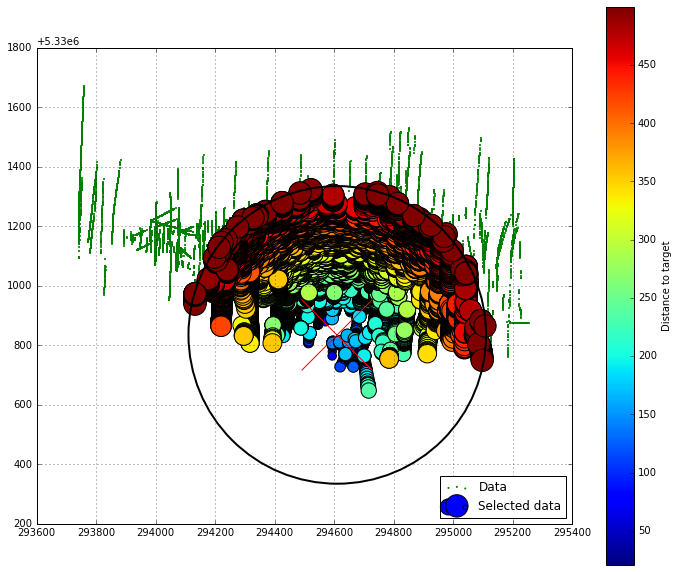

In [48]:
# get more data this time
n = mydholedb.table['dholes_no_gaps']['xm'].values.shape[0]
mysearch.get_data(target=t, k=n)

# plot data selected in 2D
from matplotlib.patches import Ellipse


fig= plt.figure(num=None, figsize=(12, 10), dpi=200, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)

plt.hold(True)
ax.scatter(mydholedb.table['dholes_no_gaps']['xm'],
         mydholedb.table['dholes_no_gaps']['ym'],  color='g', s=1,  label = 'Data')



plt.scatter(mydholedb.table['dholes_no_gaps']['xm'].iloc[mysearch.selected_data],
            mydholedb.table['dholes_no_gaps']['ym'].iloc[mysearch.selected_data],  
            s=mysearch.distance_data2target, 
            c=mysearch.distance_data2target, alpha=1, label = 'Selected data')
plt.hold(True)

# width=1000, height=1000 is 2* 500 search, see axis=[500,500,500] at mysearch definition
e1 = Ellipse((mymodel.bmtable['XC'][t], mymodel.bmtable['YC'][t]), width=1000, height=1000,
             angle=0, linewidth=2, fill=False, zorder=2)

ax.add_patch(e1)

plt.hold(True)


l=plt.colorbar()
l.set_label('Distance to target')
plt.legend(loc=4)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

plt.scatter(mymodel.bmtable['XC'][t],mymodel.bmtable['YC'][t], marker='x', c= 'r', s= 5000, label= 'Target point')

plt.hold(True)

plt.show()

### Test apply results

The Neighborhood instance can apply an arbitrary function to each target node in the block. This function can be designed by the user as any thing from mean distance data - block to Kriging, or any advanced Machine Learning algorithm. 

In this example we show how to create an user defined function and apply this function over each block. 

First define a function with the following architecture: 

``` python

def user_function_name(self, <optional> some_parameters ):
    
    #do something here

    return [<list of values>]

```

Then you can apply this function as 

``my_neighborhood.apply_interpolator(interpolator,parameters={},dtypes=[float], scale=1., k=1) ``

where scale and k are the expansion factor of the search ellipse and the number of samples to use. The interpolator is a function object (your user defined function), parameters is a dictionary with the parameters required by your function and dtypes is a list with the right data types of the output of your function. 

<br>

<div class="alert alert-info">
    **Info**: Make sure to include self as argument and to define the output as a list of values with the right dtypes.  
</div>


In [49]:
# we create an interpolation function, in this case the mean distance data-target

def meandist(self):
    return [np.average(self.distance_data2target), len(self.distance_data2target)]

In [50]:
# redefine Neighborhood
mysearch=gslib.neighborhood.Neighborhood(mymodel.bmtable['XC'].values,
                      mymodel.bmtable['YC'].values,
                      mymodel.bmtable['ZC'].values,
                      mydholedb.table['dholes_no_gaps']['xm'].values,
                      mydholedb.table['dholes_no_gaps']['ym'].values,
                      mydholedb.table['dholes_no_gaps']['zm'].values,
                      target_properies=mymodel.bmtable['meandis'].values,
                      data_properies=mydholedb.table['dholes_no_gaps']['AU_AVG_GT'].values,
                      angles=[0,0,0],
                      axis=[100,100,50],
                      leafsize=1000000)

In [54]:
# now we test the apply function
%time a=mysearch.apply_interpolator(meandist, dtypes=[float, float], k=100)

CPU times: user 43.6 s, sys: 20 ms, total: 43.6 s
Wall time: 43.6 s


In [55]:
# now we test the apply function compiled in Cython
#%time a=mysearch.apply_interpolator(gslib.interpolators.meandist, k=100)

In [56]:
# add results to bmodel
mymodel.bmtable['dist']=a[0]
mymodel.bmtable['nsam']=a[1]

In [57]:
#export results
mymodel.blocks2vtkRectilinearGrid('../datasets/dhole_data2/blocks')

This is the result (view as a slice)

** TODO: ** update 

<img src='figures/dist.png'>

This data can be processed in paraview to extract surfaces by distance. The process is simple:

- convert cell data to point data
- do isovolume with 0 < dist < 100
- extract surface
- triangulate (required to export to stl)

This is the output in freecad: 

<img src='figures/surf_100.png'>



This is the output in paraview: 

<img src='figures/surf_100_paraview.png'>
